# Test loading objects and controlling robot

Navigate to root directory

In [1]:
cd ..

/home/p300488/cognitive_robotics_LLM_planning/cognitive_robotics_LLM_based_manipulation


Imports

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
from pprint import pprint
import cv2

# helper function
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()


In [3]:
from env.env import *
from env.camera import Camera
from env.objects import YcbObjects

pybullet build time: Nov 28 2023 23:51:11


Setup a scene. This will pop-up a Pybullet client in your screen. You can use the `seed` parameter to make sure the same objects and scene configuration will be loaded, leave empty for random scene.

In [4]:
# load camera and env
center_x, center_y, center_z = CAM_X, CAM_Y, CAM_Z
camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40)
env = Environment(camera, vis=True, asset_root='./env/assets', debug=False, finger_length=0.06)

# load objects
objects = YcbObjects('./env/assets/ycb_objects',
                    mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                    mod_stiffness=['Strawberry'],
                    seed=23
)
objects.shuffle_objects()

n_objects = 5

for obj_name in objects.obj_names[:n_objects]:
    path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
    env.load_isolated_obj(path, obj_name, mod_orn, mod_stiffness)
env.dummy_simulation_steps(10)

Visualize RGB-D and ground-truth segmentation from simulator.

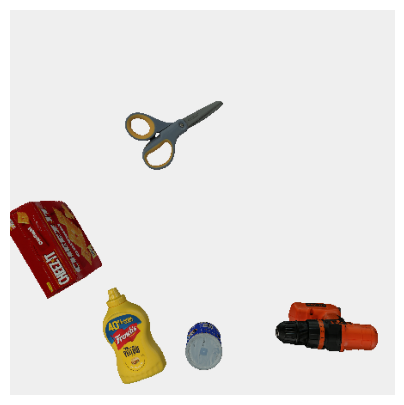

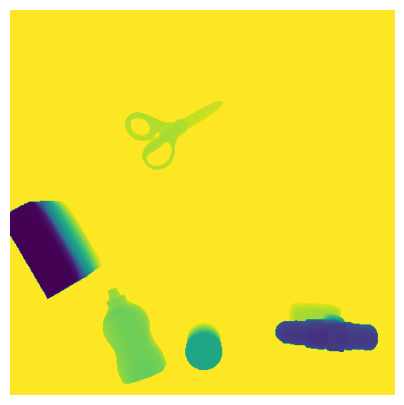

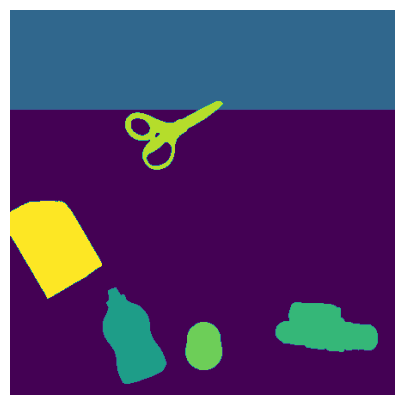

In [5]:
# visualize percepts
image, depth, seg = env.camera.get_cam_img()
display_image(image, size=(5,5))
display_image(depth, size=(5,5))
display_image(seg, size=(5,5))

Retrieve object state from simulator. This will give you the name, the pose (position + orientation in quaternion) and the unique ID of each object in Pybullet state.

In [6]:
# show object state
state = env.get_obj_states()
state_ids = {int(x['id']): x for x in state}
pprint(state_ids)

{6: {'id': 6,
     'name': 'MustardBottle',
     'orn': (0.6065258669209899,
             -0.3667675448625324,
             -0.5615698247956252,
             -0.4269042898241511),
     'pos': (-0.0927835522128006, -0.81265864948294, 0.8164260920649801)},
 7: {'id': 7,
     'name': 'PowerDrill',
     'orn': (0.015389590986424994,
             -0.014842601678165836,
             0.9992913718612185,
             0.030977601398715995),
     'pos': (0.2928820207588626, -0.7582552042896138, 0.8483089131787838)},
 8: {'id': 8,
     'name': 'MasterChefCan',
     'orn': (-3.1094610417088306e-05,
             -6.102392542708566e-06,
             0.8337884105444502,
             0.5520841289492437),
     'pos': (0.04894161016096189, -0.8082509299893799, 0.8372467870654831)},
 9: {'id': 9,
     'name': 'Scissors',
     'orn': (-0.0027844479012602633,
             0.03680488843299998,
             0.3291976593457609,
             0.9435393728502229),
     'pos': (-0.009799578551955509, -0.366666583

## GR-ConvNet Grasp Synthesis Network

In [7]:
from grconvnet import load_grasp_generator

grasp_generator = load_grasp_generator(camera)

INFO:root:CUDA detected. Running with GPU acceleration.


224


<Figure size 1000x1000 with 0 Axes>

In [8]:
# run inference with GR-ConvNet grasp generator on given enviroment
def setup_grasps(env, grasp_generator, visualise_grasps=False):
        rgb, depth, seg = env.camera.get_cam_img()    
        img_size = grasp_generator.IMG_WIDTH
        if  img_size != camera.width: 
            rgb = cv2.resize(rgb, (img_size, img_size))
            depth = cv2.resize(depth, (img_size, img_size))  
        for obj_id in env.obj_ids:
            mask = seg == obj_id
            if img_size != camera.width:
                mask = np.array(Image.fromarray(mask).resize((img_size, img_size), Image.LANCZOS))
            grasps = grasp_generator.predict_grasp_from_mask(rgb,
                                                           depth,
                                                           mask,
                                                           n_grasps=5, 
                                                           show_output=False
            )
            env.set_obj_grasps(obj_id, grasps)
        
        if visualise_grasps:
            LID =[]
            for obj_id in env.obj_ids:
                grasps = env.get_obj_grasps(obj_id)
                color = np.random.rand(3).tolist()
                for g in grasps:
                    LID = env.draw_predicted_grasp(g,color=color,lineIDs=LID)
            
            time.sleep(5)
            env.remove_drawing(LID)
            env.dummy_simulation_steps(10)

### Motion primitive for moving the arm to desired location

In [9]:
# move ee primitive
target_id = 7 # power drill object
ee_x, ee_y, ee_z = state_ids[target_id]['pos'] # object center from state
ee_z += 0.35 # go a bit higher
ee_orn = p.getQuaternionFromEuler([-np.pi*0.25, np.pi/2, 0.0]) # approach from above
_ = env.move_ee([ee_x, ee_y, ee_z, ee_orn])

You can reset the robot.

In [10]:
env.reset_robot()
env.dummy_simulation_steps(10)

### Pick and Place primitives

Run Gr-ConvNet to detect graps from the RGB-D scene. Then use the segmentation mask to separate and match each grasp to an object. See `grconvnet.py` the `predict_grasp_from_mask` method for details on how this is implemented.

In [11]:
# run and visualize grasps
setup_grasps(env, grasp_generator, visualise_grasps=True)

You should see per-object top-down grasps shown in your Pybullet client. 

In [12]:
# pick obj primitive
target_id = 6 # mustard bottle object
_ = env.pick_obj(target_id)

You can define a place location for the grasped object. These can be:
* table locations (e.g. top side, left side, top right corner, bottom left corner etc. - see `env/env.py` for details.
* exact 3D positions

In [13]:
# place object in table location primitive
target_loc = "left side"
_ = env.place_in_loc(target_loc)

You can reset the robot, the scene and the grasps

In [14]:
env.reset_robot()
env.dummy_simulation_steps(10)
env.reset_all_obj()
env.dummy_simulation_steps(10)
env.update_obj_states()
setup_grasps(env, grasp_generator)

Or do the same but place in specific location.

In [15]:
target_id = 6 # mustard bottle object
_ = env.pick_obj(target_id)

# place object in exact location primitive
target_id = 7 # power drill object
ee_x, ee_y, ee_z = state_ids[target_id]['pos'] # object center from state
ee_y += 0.1 # go a bit in front
ee_x -= 0.1 # bit to the right
ee_z += 0.35 # and a bit higher
target_loc = [ee_x, ee_y, ee_z]
_ = env.place_in_loc(target_loc)

The above is doing pick-and-place separately. They are united in a single primitive `put_obj_in_loc`.

In [16]:
env.reset_robot()
env.dummy_simulation_steps(10)
env.reset_all_obj()
env.dummy_simulation_steps(10)
env.update_obj_states()
setup_grasps(env, grasp_generator)

# pick and place primitive
target_id = 6 # mustard bottle object
target_loc = "left side"
_ = env.put_obj_in_loc(target_id, target_loc)

env.reset_robot()
env.dummy_simulation_steps(10)
env.reset_all_obj()
env.dummy_simulation_steps(10)
env.update_obj_states()
setup_grasps(env, grasp_generator)

# pick and place primitive
target_id = 6 # mustard bottle object
target_loc = [ee_x, ee_y, ee_z]
_ = env.put_obj_in_loc(target_id, target_loc)

### Clean object primitive (put in tray)

In [17]:
env.reset_robot()
env.dummy_simulation_steps(10)
env.reset_all_obj()
env.dummy_simulation_steps(10)
env.update_obj_states()
setup_grasps(env, grasp_generator)

In [18]:
# clean primitive - put objects in tray
target_ids = [7,9,10] # power drill, scissors, cracker box
for tgt in target_ids:
    env.clean_obj(tgt)

Grasping failed. Retrying...
Grasping failed. Retrying...
Grasping failed. Retrying...
Grasping failed. Retrying...
Grasping failed. Retrying...
Grasping failed. Retrying...


In [19]:
# close client
p.disconnect()